# MORE-ML user guide using MORE-QX dataset


In [62]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import seaborn as sns
import numpy as np
from joblib import delayed, Parallel 
import re
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import re
import os
from IPython.display import Latex
plt.style.use(['tableau-colorblind10'])
from adjustText import adjust_text
import matplotlib.patches as patches
import matplotlib.ticker as mtick
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator 
mpl.rcParams.update(mpl.rcParamsDefault)

%matplotlib inline
color={'toluene':'#8ECFC9','ethanol':'#FFBE7A','2-Furfurylthiol':'#FA7F6F','guaiacol':'#82B0D2','Hell_1':'#BEB8DC','Hell_2':'#E7DAD2','Cp3':'#999999','Cp1':'#287885','Cp2':'C82423','blue':'#2878B5','red':'#FF8884'}
plt.rcParams['legend.frameon'] = False
plt.rcParams.update({'font.size': 24}) 
plt.rcParams['axes.labelpad'] = 12

plt.rcParams['axes.labelpad'] = 12
plt.rcParams['axes.linewidth'] = 2

import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,      
    r2_score,                 
    mean_absolute_error,       
    pairwise,                  
    root_mean_squared_error, 
)

#SHAP analysis
import shap 
shap.initjs()

#save df from hdf5|
from joblib import dump, load

import umap
from tqdm import tqdm
import json

color_maps = {'grey':'#616163','green':'#44FFD2','blue':'#44FFD2','red':'#FFBFA0'}
colors = {'black':'#0A0908','blue':'#22333B','white':'#EAE0D5','green':'#C6AC8F','brown':'#5E503F','yellow':'#FFBA08'}

In [2]:
%run ex_createDF.py -ds 'all'

All subsets will be printed


100%|██████████| 102/102 [00:17<00:00,  5.85it/s]


G1_OM printed


100%|██████████| 18/18 [00:02<00:00,  6.44it/s]


G1_REC printed


100%|██████████| 18/18 [1:00:19<00:00, 201.09s/it]


G2_XTB_REC printed


100%|██████████| 18/18 [40:11<00:00, 133.95s/it]


G2_XTB_OM printed


100%|██████████| 18/18 [49:36<00:00, 165.36s/it]


G2_XTB_DM printed


100%|██████████| 18/18 [33:23<00:00, 111.30s/it]


G2_XTB_ORCA_OM printed


100%|██████████| 18/18 [38:24<00:00, 128.02s/it]


G2_XTB_ORCA_REC printed


100%|██████████| 18/18 [34:18<00:00, 114.38s/it]


G2_XRB_ORCA_DM printed


100%|██████████| 18/18 [15:40<00:00, 52.27s/it]


G3_VASP_CPLX printed


100%|██████████| 18/18 [21:12<00:00, 70.68s/it]


G3_VASP_OM printed


100%|██████████| 18/18 [16:54<00:00, 56.36s/it]


G3_VASP_SUB printed


100%|██████████| 18/18 [05:39<00:00, 18.85s/it]


G3_VASP_BD printed
All subsets printed


## Load the input feature

In [4]:
#read 
#complex system 
CPLX_VASP_df = load('./G3_VASP_CPLX.joblib')
SUB_VASP_df = load('./G3_VASP_SUB.joblib')
OM_VASP_df = load('./G3_VASP_OM.joblib')
BD_VASP_df = load('./G3_VASP_BD.joblib')
#monomer 
OM_df = load('./G1_OM.joblib')
REC_df = load('./G1_REC.joblib')
#xtb dimer 
XTB_df_OM = load('./G2_XTB_OM.joblib')
XTB_df_REC = load('./G2_XTB_REC.joblib') 
XTB_df_DM = load('./G2_XTB_DM.joblib')
#orca dimer 
XTB_ORCA_df_OM = load('./G2_XTB_ORCA_OM.joblib')
XTB_ORCA_df_REC = load('./G2_XTB_ORCA_REC.joblib')
XTB_ORCA_df_DM = load('./G2_XTB_ORCA_DM.joblib')

In [31]:
#monomer
df_rec = REC_df.copy()
df_om = OM_df.copy()
#dimer orca
df_dm_om_orca = XTB_ORCA_df_OM.copy()
df_dm_rec_orca = XTB_ORCA_df_REC.copy()
df_dm_orca = XTB_ORCA_df_DM.copy()
#dimer xtb
df_dm_om_xtb = XTB_df_OM.copy()
df_dm_rec_xtb = XTB_df_REC.copy()
df_dm_xtb = XTB_df_DM.copy()
#cplx vasp
df_cplx = CPLX_VASP_df.copy()
df_sub = SUB_VASP_df.copy()
df_bd = BD_VASP_df.copy()
df_om_vasp = OM_VASP_df.copy()

In [32]:
df_dm_orca.columns

Index(['REC', 'OM', 'DM', 'atNUM', 'atXYZ', 'ePBE+D3', 'eNUC', 'eELE', 'e1E',
       'e2E', 'ePE', 'eKE', 'eX', 'eC', 'eXC', 'eD3', 'eE6', 'eE8', 'eH', 'eL',
       'HLgap', 'eORB', 'mC6', 'vEDIP', 'vNDIP', 'vDIP', 'DIP', 'vRS',
       'vRSDIP', 'NQP', 'EQP', 'TQP', 'mQP', 'mTPOL', 'mPOL', 'RG', 'IM',
       'muCHG', 'loCHG', 'maCHG', 'vF', 'eAT', 'eBIND'],
      dtype='object')

### Extract vector features for binding feature predictions

In [33]:
#Expand vector in to input DF (vDIP,vRS,vRSDIP,TQP,IM)
def get_vec_df(X,geo):
    v_df = pd.DataFrame(X[f'{geo}'].tolist(),columns=[f'{geo}_{i+1}' for i in range(0,len(df_dm_orca[geo][0]))])
    return v_df
#v_df = get_vec_df(df_dm_orca,'IM')
#Concat vectors into DataFrame
for i in ['vDIP','vRS','vRSDIP','TQP','IM']:
    v_df = get_vec_df(df_dm_orca,i)
    df_dm_orca = pd.concat([df_dm_orca,v_df],axis=1)

In [34]:
#For OM 
for i in ['vDIP','vRS','vRSDIP','TQP','IM']:
    v_df = get_vec_df(df_dm_om_orca,i)
    df_dm_om_orca = pd.concat([df_dm_om_orca,v_df],axis=1)

In [35]:
#For REC
for i in ['vDIP','vRS','vRSDIP','TQP','IM']:
    v_df = get_vec_df(df_dm_rec_orca,i)
    df_dm_rec_orca = pd.concat([df_dm_rec_orca,v_df],axis=1)

In [36]:
#Total feature
input_labels = ['ePBE+D3', 'eNUC', 'eELE', 'e1E',
       'e2E', 'ePE', 'eKE', 'eX', 'eC', 'eXC', 'eD3', 'eE6', 'eE8', 'eH', 'eL','HLgap',
                  'mC6','DIP','mQP','mPOL','RG','eAT','eBIND','vDIP_1',
       'vDIP_2', 'vDIP_3', 'vRS_1', 'vRS_2', 'vRS_3', 'vRSDIP_1', 'vRSDIP_2',
       'vRSDIP_3', 'TQP_1', 'TQP_2', 'TQP_3', 'TQP_4', 'TQP_5', 'TQP_6',
       'IM_1', 'IM_2', 'IM_3', 'IM_4', 'IM_5', 'IM_6']

target_labels = ['eADS', 'GbaDCHG', 'RbaDCHG', 'ObaDCHG', 'DWF',
       'DD3', 'DGAP']

input_combined = [i + '_DM' for i in input_labels] + [i for i in df_dm_orca.columns if re.search(r'bob_pca_\d+_DM',i)] + [i for i in df_dm_orca.columns if re.search(r'bob_pca_\d+_DM',i)] + [i + '_REC' for i in input_labels if i != 'eBIND'] + [i + '_OM' for i in input_labels if i != 'eBIND'] 

In [37]:
# Combine DM, REC, OM features
df_dm_orca.columns = [i + '_DM' for i in df_dm_orca.columns]
df_dm_rec_orca.columns = [i + '_REC' for i in df_dm_rec_orca.columns]
df_dm_om_orca.columns = [i + '_OM' for i in df_dm_om_orca.columns]
_ = pd.concat([df_dm_orca,df_dm_rec_orca],axis=1)
_ = pd.concat([_,df_dm_om_orca],axis=1)

In [38]:
X = _[input_combined]
Y = df_bd[target_labels]
X = X.astype(float)
Y = Y.astype(float)
print('Initial feature number:',len(X.columns))

Initial feature number: 130


### Delete Outliers

In [39]:
d_outliers_idx = np.loadtxt('./outliers.dat',dtype=int)
X = X.loc[~X.index.isin(d_outliers_idx)].reset_index(drop=True) #outlier_idx
Y = Y.loc[~Y.index.isin(d_outliers_idx)].reset_index(drop=True) #outlier_idx

In [40]:
X.columns

Index(['ePBE+D3_DM', 'eNUC_DM', 'eELE_DM', 'e1E_DM', 'e2E_DM', 'ePE_DM',
       'eKE_DM', 'eX_DM', 'eC_DM', 'eXC_DM',
       ...
       'TQP_3_OM', 'TQP_4_OM', 'TQP_5_OM', 'TQP_6_OM', 'IM_1_OM', 'IM_2_OM',
       'IM_3_OM', 'IM_4_OM', 'IM_5_OM', 'IM_6_OM'],
      dtype='object', length=130)

In [41]:
Y.columns

Index(['eADS', 'GbaDCHG', 'RbaDCHG', 'ObaDCHG', 'DWF', 'DD3', 'DGAP'], dtype='object')

## Farthest point sampling for train/test splitting

In [42]:
def FPS(points,num):
    ###
    # points: point cloud (dataframe)
    # num: number of wished selected points
    
    # point starts from 0
    ###
    points.index = range(0,len(points))
    center = np.mean(points,axis=0) #Due to PCA, already shift to (0,0,0)
    n = points.shape[0] # total num of points
    fps_idx = np.zeros(num,dtype=int) # initiate the idx_list
    
    # initial points, largest distance from center
    distances = np.linalg.norm(points - center, axis=1) # axis=1 ,calculate the euclidean distance for every points
    fps_idx[0] = np.argmax(distances) # P0
    print(fps_idx[0])
    #print(distances[566])
    # calculate the distance between one point and selected_pt_group
    for i in tqdm(range(1,num)): 
        # calculate all the rest points to the selected new point
        # note that : my DataFrame starts from 1, whereas np.array starts from 0. Thats why here I added +1 in the 'loc'
        # since now dataframe starts from 0, no need + 1
        new_distances = np.linalg.norm(points.values - points.loc[[fps_idx[i-1]]].values,axis=1) 
        #print(new_distances)
        # calculate the shortest distance as the criteria for each point
        # make it more clear: take the point as criteria with the shortest distance 
        distances = np.minimum(distances,new_distances)
        #print(distances)
        # take the maximal among those distances, then it is the farthest point
        fps_idx[i] = np.argmax(distances)
    # return to the real order of combinations by +1    
    fps_idx = [idx for idx in fps_idx] 
    return fps_idx

In [43]:
tsne_labels = ['eADS','DWF','ObaDCHG']
tsne = TSNE(n_components=2, random_state=20240815, perplexity=5, n_iter=1000,n_jobs=-1)
scaler_tsne = StandardScaler()
_ = pd.concat([X,Y[tsne_labels]],axis=1)
_norm = scaler_tsne.fit_transform(Y[tsne_labels])
tsnes = pd.DataFrame(tsne.fit_transform(_norm))

/data/horse/ws/lich841a-alpha/user-kernel/my-kernel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


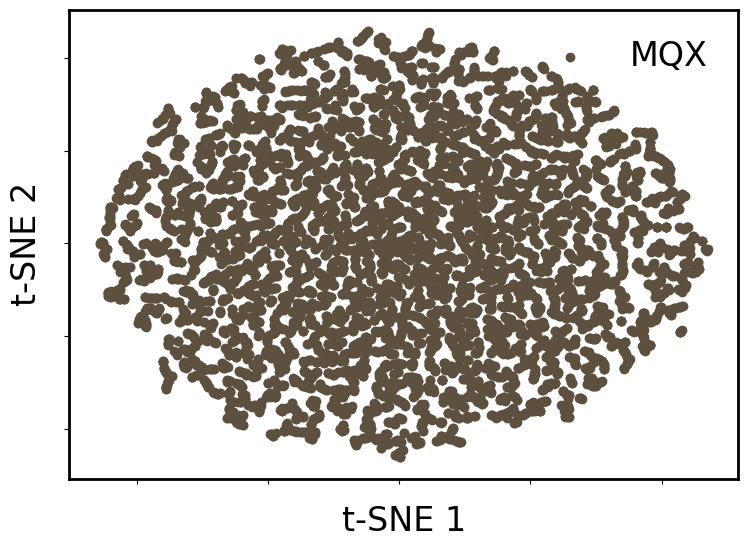

In [44]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(tsnes[0],tsnes[1],label='MQX',c=colors['brown'])
#ax.scatter(tsnes[0].loc[idx_1836],tsnes[1].loc[idx_1836],s=20,label='MORE-Q',c=colors['white'],alpha=0.5)
#ax.scatter(tsnes[0],tsnes[1],s=5)
#plt.xticklabels(' ')
#plt.yticklabels(' ')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_xticklabels([])  # X 轴刻度标签为空
ax.set_yticklabels([])
ax.legend(frameon=False,fancybox=False)
plt.tight_layout()
plt.show()

In [45]:
tsnes_df = pd.DataFrame(tsnes)
selected_labels = FPS(tsnes_df,8563) # 9:1 train/test

1814


100%|██████████| 8562/8562 [00:04<00:00, 1789.77it/s]


In [46]:
#get X_train, Y_train, X_test, Y_test
X_train = X.loc[selected_labels].copy()
Y_train = Y.loc[selected_labels].copy()

# to get the test idx
test_idx = [i for i in X.index if i not in selected_labels]# 必须要统一不然会有数据泄露
X_test = X.loc[test_idx].copy()
#X_test = np.array([i for i in eq_test]
Y_test = Y.loc[test_idx].copy()

In [47]:
#Take Work function change as an example
target='DWF'
y_train = Y_train[target]
y_test = Y_test[target]

In [48]:
# Final Features for Eads
eads_labels = ['IM_3_DM', 'IM_6_OM', 'IM_5_OM', 'eC_OM', 'vRS_2_DM', 'eBIND_DM', 'RG_OM', 'IM_5_DM', 'vRS_2_OM', 'IM_6_DM', 'TQP_1_OM', 'mC6_OM', 'mPOL_OM', 'eKE_OM', 'TQP_2_OM', 'IM_2_DM', 'mQP_OM', 'IM_4_OM', 'eL_OM', 'RG_DM', 'vRS_3_OM', 'TQP_3_OM', 'eELE_OM', 'eAT_OM', 'IM_2_OM', 'IM_4_DM', 'eX_OM', 'vDIP_1_OM', 'IM_1_DM', 'eH_OM', 'IM_3_OM', 'TQP_4_REC', 'vRS_3_DM', 'TQP_5_DM', 'vRSDIP_1_REC', 'TQP_4_DM', 'vRS_1_OM', 'eH_DM', 'vRS_1_DM', 'vDIP_2_DM', 'TQP_6_DM', 'TQP_1_REC', 'TQP_5_OM', 'eL_DM', 'vDIP_2_REC', 'DIP_OM', 'vRSDIP_3_DM', 'TQP_6_OM', 'DIP_REC', 'eNUC_OM']

# Final Features for \Delta \phi
DWF_labels = ['eH_DM', 'vDIP_3_OM', 'vDIP_3_DM', 'TQP_1_REC', 'TQP_3_DM', 'eH_REC', 'DIP_REC', 'eC_OM', 'eL_REC', 'HLgap_DM', 'IM_6_REC', 'vRS_1_OM', 'DIP_OM', 'IM_5_OM', 'TQP_6_DM', 'IM_6_DM', 'eKE_OM', 'TQP_5_OM', 'HLgap_OM', 'TQP_1_OM', 'IM_6_OM', 'IM_5_DM', 'vRSDIP_2_OM', 'vRSDIP_2_DM', 'TQP_4_REC', 'IM_1_OM', 'TQP_4_DM', 'ePBE+D3_OM', 'HLgap_REC', 'TQP_4_OM', 'eELE_OM', 'eL_OM', 'vRS_1_REC', 'eH_OM', 'ePE_OM', 'vRSDIP_1_REC', 'eD3_DM', 'vRSDIP_1_DM', 'TQP_6_OM', 'IM_4_OM', 'vRSDIP_3_DM', 'vDIP_2_DM', 'eL_DM', 'vRSDIP_3_REC', 'TQP_5_DM', 'vRSDIP_3_OM', 'e2E_OM', 'IM_4_DM', 'IM_2_DM', 'mPOL_OM', 'IM_1_DM', 'mQP_OM', 'vRSDIP_1_OM', 'vDIP_1_DM', 'DIP_DM', 'vRS_2_REC', 'vDIP_2_OM', 'vRS_1_DM', 'IM_3_OM', 'vRS_3_REC']

# Final Feature for \Delta Q
DQ_labels = ['TQP_4_REC', 'vDIP_3_DM', 'vRS_2_OM', 'DIP_OM', 'eH_OM', 'TQP_3_OM', 'eH_DM', 'RG_DM', 'TQP_4_DM', 'IM_6_DM', 'eL_OM', 'RG_OM', 'IM_4_OM', 'vRS_1_OM', 'vDIP_3_REC', 'ePBE+D3_OM', 'IM_3_DM', 'eH_REC', 'IM_6_OM', 'mPOL_OM', 'vRS_1_DM', 'vRS_3_DM', 'vRS_2_DM', 'IM_5_DM', 'TQP_1_OM', 'TQP_2_OM', 'IM_5_OM', 'ePE_OM', 'vRS_3_OM', 'IM_4_DM', 'IM_2_OM', 'TQP_5_DM', 'vDIP_2_REC', 'vDIP_1_DM', 'vDIP_2_DM', 'eAT_OM', 'IM_5_REC', 'vRSDIP_1_REC', 'TQP_5_OM', 'vRSDIP_3_DM', 'TQP_3_DM', 'IM_3_OM', 'mPOL_REC', 'TQP_6_DM', 'vRSDIP_3_REC', 'vRS_1_REC', 'IM_1_OM', 'TQP_4_OM', 'vRSDIP_2_REC', 'vRSDIP_2_OM', 'vDIP_3_OM', 'mQP_OM', 'DIP_REC', 'vRSDIP_1_OM', 'vRSDIP_2_DM', 'TQP_6_REC', 'DIP_DM', 'TQP_1_REC', 'vDIP_1_OM', 'mC6_OM', 'TQP_6_OM', 'ePBE+D3_DM', 'vRSDIP_1_DM', 'eL_DM', 'eXC_OM', 'e1E_DM', 'TQP_1_DM', 'TQP_2_DM', 'eNUC_OM', 'eXC_DM', 'e2E_DM', 'eBIND_DM', 'e1E_OM', 'ePE_DM', 'vDIP_2_OM', 'vRS_3_REC', 'vRSDIP_3_OM', 'IM_6_REC', 'IM_1_DM', 'eELE_DM']


In [49]:
X_train = X_train[DWF_labels]
X_test = X_test[DWF_labels]

## Loading the model

In [51]:
#CATBOOST REGRESSOR
import catboost as cat
catr = {
    #cat regressor
    "model": cat.CatBoostRegressor()
}
#Best hyperparameters obtained from Bayesian optimization
#Eads
#best_params = {'iterations': 7000, 'learning_rate': 0.02, 'depth': 7, 'l2_leaf_reg': 9.24, 'border_count': 178}
#DWF
best_params = {'iterations': 5000, 'learning_rate': 0.01, 'depth': 7, 'l2_leaf_reg': 2.387, 'border_count': 147}
#ObaDCHG
#best_params = {'iterations': 7000, 'learning_rate': 0.02, 'depth': 7, 'l2_leaf_reg': 1.341, 'border_count': 169}

In [52]:
trained_model = catr['model'].set_params(**best_params)

In [53]:
#quick eval
def md_evl(y,y_pred):
    r2 = r2_score(y,y_pred)
    #re
    re = np.abs((np.array(y) - np.array(y_pred))/np.array(y))
    mre = np.mean(re)
    mae_ = mean_absolute_error(y,y_pred)
    mse = mean_squared_error(y,y_pred)
    rmse = root_mean_squared_error(y,y_pred)
    #re = mae_ / np.mean(y)
    #print(r2,mae_,mre,mse,rmse)
    return r2, mae_, mre, mse, rmse
    
def get_im_4_sqs(trained_model,X_train,X_test,y_train,y_test): #,target=target,*args
    #pipeline = Pipeline([('scaler',StandardScaler()),
    #                     ('model',trained_model)
    #]    
    #)
    
    scaler_x = StandardScaler()
    X_train_norm = scaler_x.fit_transform(X_train)
    X_test_norm = scaler_x.transform(X_test)
    model = trained_model.fit(X_train_norm,y_train)
        
    #For X_train
    y_pred_train = model.predict(X_train_norm)
    
    evl_train = md_evl(y_train.values,y_pred_train) # r2, mae_, mre

    #For X_test
    y_pred_test = model.predict(X_test_norm) # r2, mae_, mre

    evl_test = md_evl(y_test,y_pred_test)

    return y_pred_train, y_pred_test, evl_train, evl_test

## Evaluation on test set

In [54]:
y_pred_train, y_pred_test, evl_train, evl_test = get_im_4_sqs(trained_model,X_train,X_test,y_train,y_test)
print(target)
print('       r2                    mae                mre                   mse                 rmse       ')
print(evl_train)
print(evl_test)

TBB Warning: The number of workers is currently limited to 15. The request for 255 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 0.1228870	total: 126ms	remaining: 10m 32s
1:	learn: 0.1222291	total: 133ms	remaining: 5m 31s
2:	learn: 0.1215961	total: 138ms	remaining: 3m 49s
3:	learn: 0.1209665	total: 142ms	remaining: 2m 57s
4:	learn: 0.1203521	total: 147ms	remaining: 2m 26s
5:	learn: 0.1197269	total: 152ms	remaining: 2m 6s
6:	learn: 0.1190982	total: 156ms	remaining: 1m 51s
7:	learn: 0.1184984	total: 161ms	remaining: 1m 40s
8:	learn: 0.1179025	total: 167ms	remaining: 1m 32s
9:	learn: 0.1173123	total: 171ms	remaining: 1m 25s
10:	learn: 0.1167383	total: 176ms	remaining: 1m 19s
11:	learn: 0.1161418	total: 180ms	remaining: 1m 14s
12:	learn: 0.1155697	total: 185ms	remaining: 1m 10s
13:	learn: 0.1150046	total: 189ms	remaining: 1m 7s
14:	learn: 0.1144457	total: 195ms	remaining: 1m 4s
15:	learn: 0.1139037	total: 200ms	remaining: 1m 2s
16:	learn: 0.1133730	total: 205ms	remaining: 60s
17:	learn: 0.1127746	total: 209ms	remaining: 57.9s
18:	learn: 0.1122594	total: 214ms	remaining: 56s
19:	learn: 0.1117178	total: 218m

## Model explanation for $\Delta \phi$ prediction example

### SHAP analysis

In [56]:
#Load explainer
explainer = shap.TreeExplainer(trained_model)
scaler = StandardScaler()
scaler.fit(X_train[DWF_labels])  
X_norm = scaler.transform(X[DWF_labels])
X_norm_df = pd.DataFrame(
    scaler.transform(X[DWF_labels]),
    columns=DWF_labels,  
    index=X.index)
shap_values = explainer(X_norm_df)

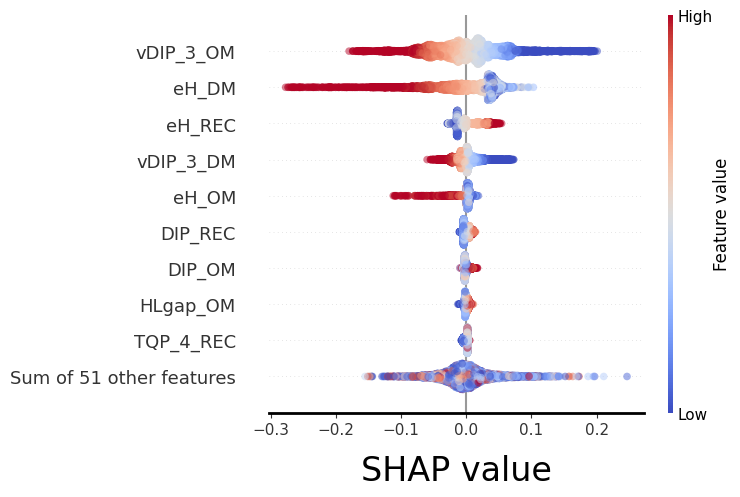

In [57]:
#Get feature importance
fig, ax = plt.subplots(figsize=(8, 7))
plt.sca(ax)
shap.plots.beeswarm(shap_values,max_display=10,alpha=0.5,color=plt.get_cmap("coolwarm"),show=False,s=30) #,
ax.set_xlabel("SHAP value", fontsize=24)
ax.xaxis.set_major_locator(MaxNLocator(6))
plt.tight_layout()
plt.show()

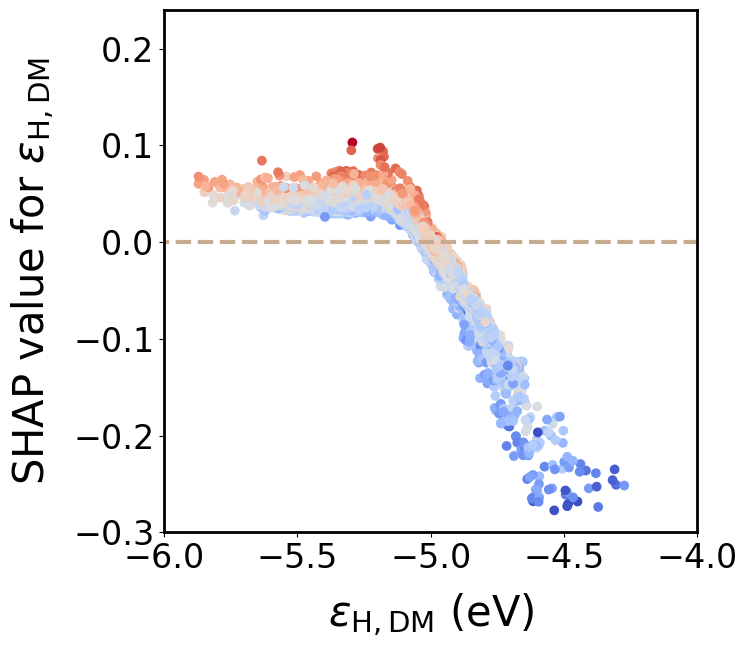

In [58]:
#Contribution behavior of DM HOMO energy
fig, ax = plt.subplots(figsize=(8,7))
#x = shap_values[:,'eH_DM'].data
x = X.eH_DM
y = shap_values[:,'eH_DM'].values

scatter = ax.scatter(x,y,c=Y.DWF,alpha=1,cmap='coolwarm')# #cmap='GnBu' c=X.vDIP_3_OM,
ax.set_xlabel('$\epsilon_{\mathrm{H,DM}}$ (eV)',fontsize=30)
ax.set_ylabel('SHAP value for $\epsilon_{\mathrm{H,DM}}$',fontsize=30)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.axhline(0,-10,10,lw=3,ls='--',c=colors['green'])
ax.set_ylim(-0.3,0.24)
ax.set_xlim(-6,-4)
counts, bin_edges = np.histogram(x, bins=100)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1] - bin_edges[0]
plt.tight_layout()
plt.show()

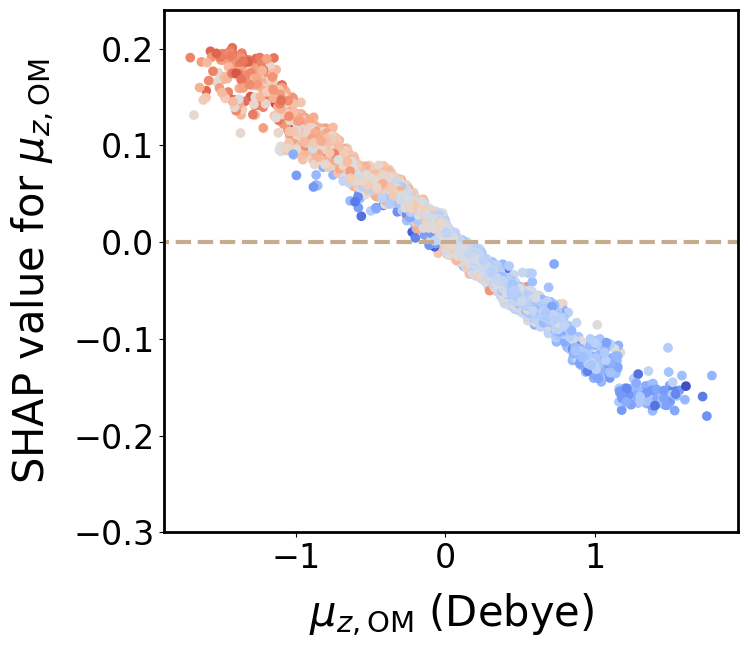

In [59]:
#Contribution behavior of OM dipole moment
fig, ax = plt.subplots(figsize=(8,7))
#x = shap_values[:,'vDIP_3_OM'].data
x = X.vDIP_3_OM
y = shap_values[:,'vDIP_3_OM'].values
scatter = ax.scatter(x,y,c=Y.DWF,alpha=1,cmap='coolwarm') #  #X.eH_DM
ax.set_xlabel('$\mu_{z,\mathrm{OM}}$ (Debye)',fontsize=30)
ax.set_ylabel('SHAP value for $\mu_{z,\mathrm{OM}}$',fontsize=30)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.axhline(0,-10,10,lw=3,ls='--',c=colors['green'])
ax.set_ylim(-0.3,0.24)

#colorbar 
#cb = plt.colorbar(scatter) #,cax=cb_ax
#cb.set_label(r'$\Delta \phi$ (eV)',fontsize=24,loc='center',labelpad=5)
#cb.ax.tick_params(labelsize=24)



counts, bin_edges = np.histogram(x, bins=100)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1] - bin_edges[0]


plt.tight_layout()
plt.show()

### Inherent tree model explanation for Work function change

In [60]:
model = trained_model.fit(X_norm_df,Y.DWF)
model.save_model('DWF_cat.json',format='json')

0:	learn: 0.1234835	total: 5.41ms	remaining: 27s
1:	learn: 0.1228250	total: 10.7ms	remaining: 26.8s
2:	learn: 0.1221817	total: 16.1ms	remaining: 26.8s
3:	learn: 0.1215403	total: 20.7ms	remaining: 25.9s
4:	learn: 0.1209213	total: 25.1ms	remaining: 25.1s
5:	learn: 0.1203096	total: 30.1ms	remaining: 25.1s
6:	learn: 0.1196593	total: 34.7ms	remaining: 24.7s
7:	learn: 0.1190908	total: 39.2ms	remaining: 24.5s
8:	learn: 0.1185222	total: 43.6ms	remaining: 24.2s
9:	learn: 0.1178877	total: 48ms	remaining: 23.9s
10:	learn: 0.1172663	total: 52.3ms	remaining: 23.7s
11:	learn: 0.1166726	total: 57.4ms	remaining: 23.8s
12:	learn: 0.1160957	total: 61.7ms	remaining: 23.7s
13:	learn: 0.1155242	total: 66.3ms	remaining: 23.6s
14:	learn: 0.1149642	total: 70.9ms	remaining: 23.6s
15:	learn: 0.1144257	total: 75.3ms	remaining: 23.4s
16:	learn: 0.1138911	total: 80.2ms	remaining: 23.5s
17:	learn: 0.1133448	total: 84.9ms	remaining: 23.5s
18:	learn: 0.1128082	total: 89.8ms	remaining: 23.5s
19:	learn: 0.1122851	total

In [68]:
#get feature labels
top_idx = np.argsort(np.abs(shap_values.values).mean(axis=0))[::-1][:]
top_labels = [shap_values.feature_names[i] for i in top_idx]

In [63]:
#Load the model information
with open('DWF_cat.json','r',encoding='utf-8') as f:
    model_json = json.load(f)

In [64]:
obs = model_json['oblivious_trees']

In [69]:
#leaf values
#leaf weights
# splits
records = []
for i in tqdm(range(0,len(obs))):
    splits= obs[i]['splits']
    tree_depth = len(splits)
    for local_lvl, split in enumerate(splits):
        global_lvl = split['split_index']
        feat_idx = split['float_feature_index']
        border = split['border']
        split_tp = split['split_type']
        feat_name = top_labels[feat_idx] 
        
        records.append({
            'tree_index': i,
            'local_split_lvl':local_lvl,
            'global_split_lvl': global_lvl,
            'tree_depth': tree_depth,
            'feature_index':feat_idx,
            'feature_name':feat_name,
            'border':border,
            'split_type':split_tp,   
        }
        )
df_splits = pd.DataFrame(records)

100%|██████████| 5000/5000 [00:00<00:00, 106693.26it/s]


In [70]:
df_splits

,tree_index,local_split_lvl,global_split_lvl,tree_depth,feature_index,feature_name,border,split_type
0,0,0,184,7,1,eH_DM,-0.327977,FloatFeature
1,0,1,150,7,1,eH_DM,-1.585132,FloatFeature
2,0,2,245,7,1,eH_DM,0.507617,FloatFeature
3,0,3,140,7,0,vDIP_3_OM,1.791610,FloatFeature
4,0,4,4335,7,44,DIP_DM,-0.899106,FloatFeature
...,...,...,...,...,...,...,...,...
34995,4999,2,971,7,12,HLgap_REC,-0.613221,FloatFeature
34996,4999,3,3236,7,33,IM_5_DM,-0.347587,FloatFeature
34997,4999,4,3919,7,40,ePBE+D3_OM,-2.159492,FloatFeature
34998,4999,5,3774,7,38,TQP_1_REC,1.239863,FloatFeature


In [71]:
#Splitting frequency
eH_DM_lvl = df_splits[(df_splits['feature_name'] == 'eH_DM') & (df_splits['tree_index'] < 5000)].local_split_lvl
vDIP_3_OM_lvl = df_splits[(df_splits['feature_name'] == 'vDIP_3_OM') & (df_splits['tree_index'] < 5000) ].local_split_lvl
vDIP_3_DM_lvl =  df_splits[(df_splits['feature_name'] == 'vDIP_3_DM') & (df_splits['tree_index'] < 5000) ].local_split_lvl
eH_REC_lvl =  df_splits[(df_splits['feature_name'] == 'eH_REC') & (df_splits['tree_index'] < 5000) ].local_split_lvl

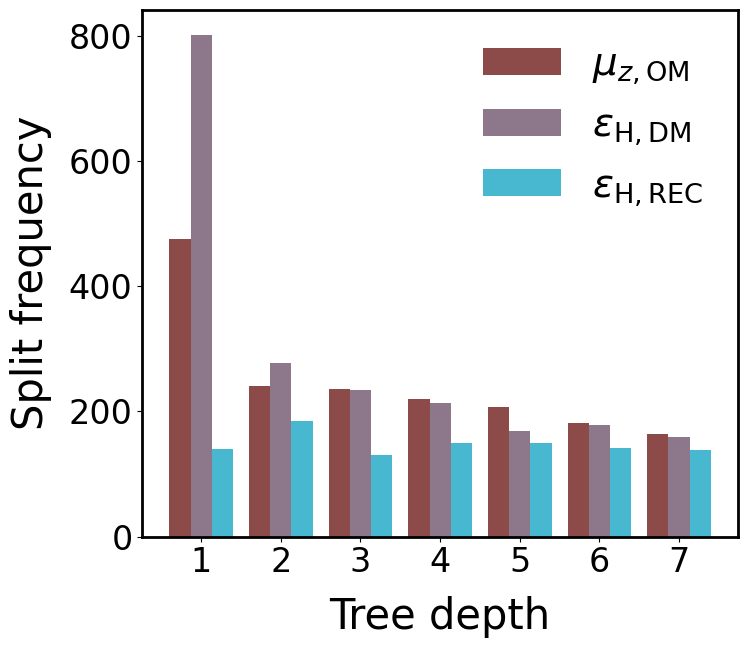

In [74]:
bins = np.arange(0, 7.5 + 1e-6, 1.0)  
colors = {'DM':'#6F1D1B','BD':'#70566D'}
# 2) Compute histograms with those bins
counts1, _ = np.histogram(vDIP_3_OM_lvl, bins=bins)
counts2, _ = np.histogram(eH_DM_lvl,      bins=bins)
counts3, _ = np.histogram(eH_REC_lvl,     bins=bins)

# 3) Bin centers are now exactly 1,2,…,7
bin_centers = (bins[:-1] + bins[1:]) / 2

# 4) Plot grouped bars around those centers
fig, ax = plt.subplots(figsize=(8,7))
width = 0.8 / 3  # total group width 0.8, each bar is a third

ax.bar(bin_centers - width, counts1, width=width,
       label=r'$\mu_{z,\mathrm{OM}}$',color=colors['DM'],alpha=0.8)
ax.bar(bin_centers,         counts2, width=width,
       label=r'$\epsilon_{\mathrm{H,DM}}$',color=colors['BD'],alpha=0.8)
ax.bar(bin_centers + width, counts3, width=width,
       label=r'$\epsilon_{\mathrm{H,REC}}$',color='#48b8d0ff')

# 5) Now use the same centers for ticks
ax.set_xticks(bin_centers)
ax.set_xticklabels(np.arange(1,8), fontsize=24)

ax.set_xlabel('Tree depth', fontsize=30)
ax.set_ylabel('Split frequency', fontsize=30)
ax.legend(fontsize=28)
plt.tight_layout()
plt.show()

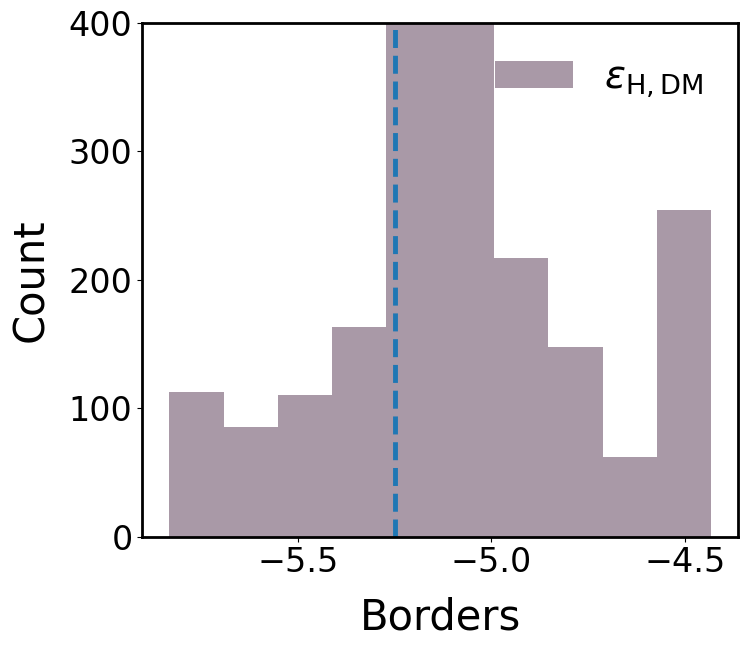

In [80]:
#border distribution
fig= plt.subplots(figsize=(8,7))
eH_DM = df_splits[(df_splits['feature_name'] == 'eH_DM') & (df_splits['tree_index'] < 5000)].border
mu = X.eH_DM.mean()
sigma = X.eH_DM.std()
eH_DM_denorm = eH_DM * sigma + mu
vDIP_3_OM = df_splits[(df_splits['feature_name'] == 'vDIP_3_OM') & (df_splits['tree_index'] < 5000) ].border
vDIP_3_DM = df_splits[(df_splits['feature_name'] == 'vDIP_3_DM') & (df_splits['tree_index'] < 5000) ].border
plt.hist(eH_DM_denorm,bins=10,label='$\epsilon_{\mathrm{H,DM}}$',alpha=0.6,color=colors['BD'])

plt.ylabel('Count',fontsize=30)
plt.xlabel('Borders',fontsize=30)
plt.ylim(0,400)
plt.vlines(x=-5.25,ymin=0,ymax=1000,lw=3.5,ls='--')


plt.legend(fontsize=28)
plt.tight_layout()
plt.show()